## Loading and Imports

In [1]:
# import pandas as pd
# import os

# # example on subset of dataset
# PATH = r'C:\Users\grede\Documents\EPFL\Master\ADA\Project\Raw\BindingDB_All.tsv'
# df = pd.read_csv(PATH, sep='\t', on_bad_lines='skip')

# df["Target Source Organism According to Curator or DataSource"].value_counts()

In [2]:
SAVE_PATH = r'C:\Users\grede\Documents\EPFL\Master\ADA\Project\Raw\homoDB.tsv'

# df = df[df["Target Source Organism According to Curator or DataSource"]=="Homo sapiens"]
# df.to_csv(path_or_buf=SAVE_PATH, sep="\t")


In [3]:
#imports
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import DataStructs
from rdkit.Chem import AllChem
import networkx as nx

import numpy as np
from sklearn.decomposition import PCA


In [4]:
df = pd.read_csv(SAVE_PATH, sep='\t', on_bad_lines='skip') #or run above cells if not saved yet

C:\Users\grede\AppData\Local\Temp\ipykernel_10876\3027052563.py:1: DtypeWarning: Columns (9,10,11,12,13,14,16,18,21,22,23,24,33,34,36,37,46,47,48,51,52,53,54,55,56,60,63,64,65,66,67,68,70,71,72,75,76,77,78,79,80,87,88,89,90,91,92,99,100,101,102,103,104,111,112,113,114,115,116,123,124,125,126,127,128,135,136,137,138,139,140,147,148,149,150,151,152,159,160,161,162,163,164,171,173,174,175,176) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(SAVE_PATH, sep='\t', on_bad_lines='skip') #or run above cells if not saved yet


In [5]:
for col in df.columns:
    print(col)

Unnamed: 0
BindingDB Reactant_set_id
Ligand SMILES
Ligand InChI
Ligand InChI Key
BindingDB MonomerID
BindingDB Ligand Name
Target Name
Target Source Organism According to Curator or DataSource
Ki (nM)
IC50 (nM)
Kd (nM)
EC50 (nM)
kon (M-1-s-1)
koff (s-1)
pH
Temp (C)
Curation/DataSource
Article DOI
BindingDB Entry DOI
PMID
PubChem AID
Patent Number
Authors
Institution
Link to Ligand in BindingDB
Link to Target in BindingDB
Link to Ligand-Target Pair in BindingDB
Ligand HET ID in PDB
PDB ID(s) for Ligand-Target Complex
PubChem CID
PubChem SID
ChEBI ID of Ligand
ChEMBL ID of Ligand
DrugBank ID of Ligand
IUPHAR_GRAC ID of Ligand
KEGG ID of Ligand
ZINC ID of Ligand
Number of Protein Chains in Target (>1 implies a multichain complex)
BindingDB Target Chain Sequence
PDB ID(s) of Target Chain
UniProt (SwissProt) Recommended Name of Target Chain
UniProt (SwissProt) Entry Name of Target Chain
UniProt (SwissProt) Primary ID of Target Chain
UniProt (SwissProt) Secondary ID(s) of Target Chain
UniPro

## Functions
(Will be moved to seperate .py file if useful)

In [6]:
def closest_dividers(n:int)->tuple:
    import math
    dividers = []
    for i in range(1,n+1):
        if n%i == 0: 
            dividers.append(i)
    mid = int(len(dividers)/2)
    if math.sqrt(n).is_integer():
        return (dividers[mid],dividers[mid])
    else:
        return (dividers[mid-1],dividers[mid])


def show_smiles_with_target(df:pd.DataFrame, title:str="", nrow:int=None, ncol:int=None, grouped_by:int=None):
    smiles_and_target = df[["Ligand SMILES","Target Name"]].reset_index()
    length = smiles_and_target.shape[0]
    if nrow and ncol:
        n_rows = nrow
        n_cols = ncol
    else:
        n_cols, n_rows = closest_dividers(length)
        
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(2*n_cols,2*n_rows))
    
    for ax, i in zip(axes.flat, np.arange(length)):
        mol = Chem.MolFromSmiles(smiles_and_target.loc[i,"Ligand SMILES"])
        tar = smiles_and_target.loc[i,"Target Name"]
        img = Draw.MolToImage(mol)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"Target: {tar}")

    if grouped_by:
        for ax, i in zip(axes.flat, np.arange(length)):
            if (i-1)%grouped_by!=0:
                ax.set_title("")
                
    fig.suptitle(title, fontweight="bold")
    plt.tight_layout()
    plt.show()


def plot_potent_chems(df_with_unique_targets:pd.DataFrame,
                      df_with_chems:pd.DataFrame,
                      chems_per_target:int=1,
                      title:str="Most Potent Ligand(s) of Each Target",
                      nrow:int=None,
                      ncol:int=None)->None:
    
    most_potent_stored = [] # store all structures
    for target in df_with_unique_targets.index:
        most_potent = df_with_chems[df_with_chems["Target Name"]==target].sort_values(by="IC50 (nM)", ascending = True)[:chems_per_target]
        most_potent_stored.append(most_potent)

    most_potent_stored = pd.concat(most_potent_stored)[["Ligand SMILES","Target Name","IC50 (nM)"]]
    show_smiles_with_target(most_potent_stored,
                            title=title,
                            grouped_by=chems_per_target,
                            ncol=ncol,
                            nrow=nrow)



def show_smiles(df:pd.DataFrame, title="", n_rows=5, n_cols=5, random_sample=False):
    unique_smiles = df["Ligand SMILES"].unique()

    n_sampled = n_rows*n_cols
    if random_sample:
        smiles = np.random.choice(unique_smiles, n_sampled, replace=False)
    else:
        smiles = unique_smiles[:n_sampled]


    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(2*n_cols,2*n_rows))

    for ax, i in zip(axes.flat, np.arange(n_sampled)):
        mol = Chem.MolFromSmiles(smiles[i])
        img = Draw.MolToImage(mol)
        ax.imshow(img)
        ax.axis("off")
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


def tanimoto_similarity(fp1, fp2):
    return DataStructs.FingerprintSimilarity(fp1, fp2)

def tanimoto_matrix(chem_df:pd.DataFrame,
                         show_every_n_labels:int=0,
                         label_type:str="Target Name",
                         title:str="Tanimoto Similarity Matrix"):
    # fingerprints
    fp_generator = AllChem.GetMorganGenerator(radius=3)
    mols = [Chem.MolFromSmiles(sm) for sm in chem_df['Ligand SMILES']]
    fingerprints = [fp_generator.GetFingerprint(mol) for mol in mols]

    # Compute the Tanimoto similarity between all pairs
    tanimoto_matrix = np.array([[tanimoto_similarity(fp1, fp2) for fp2 in fingerprints] for fp1 in fingerprints])
    fig, ax = plt.subplots(1,1)

    # plot labels
    if show_every_n_labels:
        new_labels = []
        for idx, name in enumerate(chem_df[label_type]):
            if idx%show_every_n_labels==0:
                new_labels.append(name)
            else:
                new_labels.append("")
    else:
        new_labels=""
    
    # plot
    sns.heatmap(tanimoto_matrix,
                cmap="bone",
                xticklabels=new_labels,
                yticklabels=new_labels,
                cbar_kws={'location': 'left'},
                ax=ax)
    ax.set_title(title)
    ax.yaxis.tick_right()
    plt.yticks(rotation = 0)
    plt.show()

    return tanimoto_matrix

# show_smiles(df) #just for testing

## Example Structures

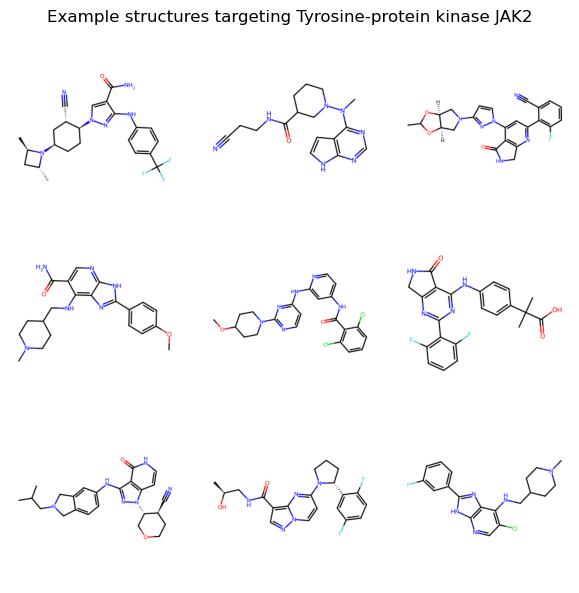

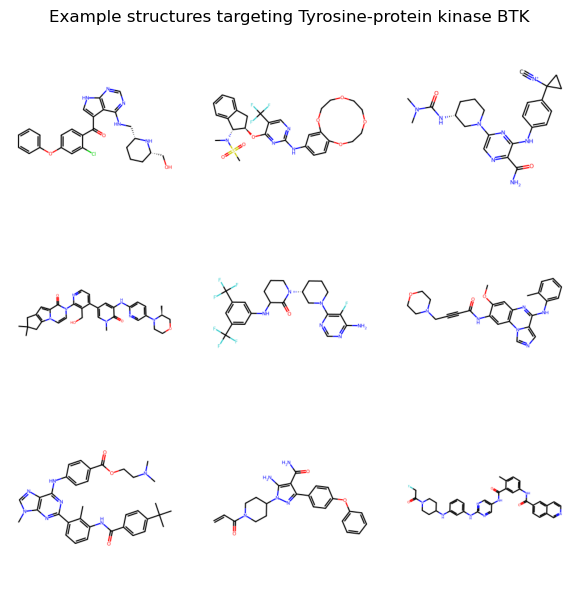

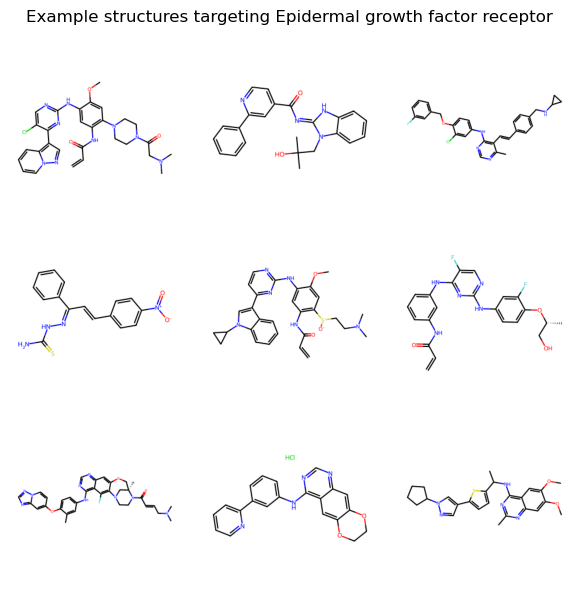

In [7]:
df[["Target Source Organism According to Curator or DataSource", "Ligand SMILES"]]

target_count = pd.DataFrame(df["Target Name"].value_counts())
target_count = target_count[target_count["count"]>20000]

for target in target_count.index:
    # print(target)
    show_smiles(df[df["Target Name"] == target],
                title=f"Example structures targeting {target}",
                n_rows=3,
                n_cols=3,
                random_sample=True,)

## Binding Kinetics

In [8]:
#looking at binding kinetics, trying to establish a ranking
df_kinetics = df[["Ligand SMILES",
                  "Target Name",
                  "Ki (nM)",
                  "IC50 (nM)",
                  "Kd (nM)",
                  "EC50 (nM)",
                  "kon (M-1-s-1)",
                  "koff (s-1)",
                  "pH",
                  "Temp (C)"]]

#number rows in homo sapiens which have available data
for col in df_kinetics.columns:
    a = df_kinetics[~df_kinetics[col].isna()].shape[0]
    print("{}:\t{:.2%}".format(col, a/1541006))
    #--> based on this, I look only ar IC50 for the moment (maybe Ki?)

Ligand SMILES:	100.00%
Target Name:	100.00%
Ki (nM):	21.01%
IC50 (nM):	66.05%
Kd (nM):	4.40%
EC50 (nM):	8.63%
kon (M-1-s-1):	0.05%
koff (s-1):	0.05%
pH:	7.49%
Temp (C):	6.82%


In [9]:
df_IC50 = df_kinetics[~df_kinetics["IC50 (nM)"].isna()]
#--> need to clean

In [10]:
def clean_single(s:str, pattern:list)->str:
    s = str(s)
    for p in pattern:
        s = s.replace(p,"")
    return float(s)

def clean_all(df:pd.DataFrame, pattern:list)->pd.DataFrame:
    df["IC50 (nM)"] = df["IC50 (nM)"].apply(clean_single, pattern=pattern)
    return df

df_IC50 = clean_all(df_IC50,[">","<"])
df_IC50 = df_IC50[df_IC50["IC50 (nM)"]!=0]

# df_IC50

C:\Users\grede\AppData\Local\Temp\ipykernel_10876\941236396.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["IC50 (nM)"] = df["IC50 (nM)"].apply(clean_single, pattern=pattern)


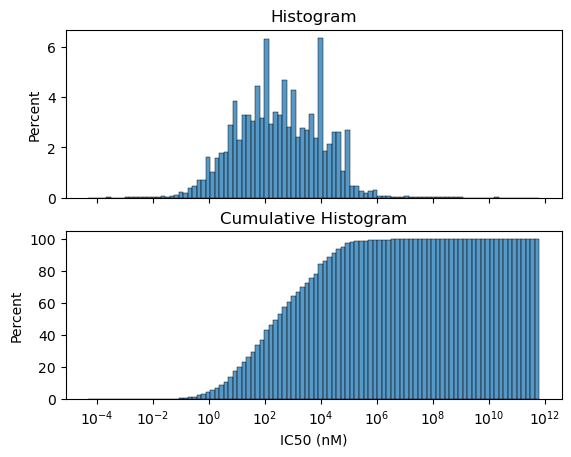

In [11]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, sharex=True)
sns.histplot(df_IC50["IC50 (nM)"], bins=100, log_scale=(True, False), element="bars", stat="percent", ax=axes[0])
axes[0].set_title("Histogram")
sns.histplot(df_IC50["IC50 (nM)"], bins=100, log_scale=(True, False), element="bars", stat="percent", cumulative=True, ax=axes[1])
axes[1].set_title("Cumulative Histogram")
plt.show()

## Most Targeted

C:\Users\grede\AppData\Local\Temp\ipykernel_10876\2767383797.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = df_only_most_targeted,


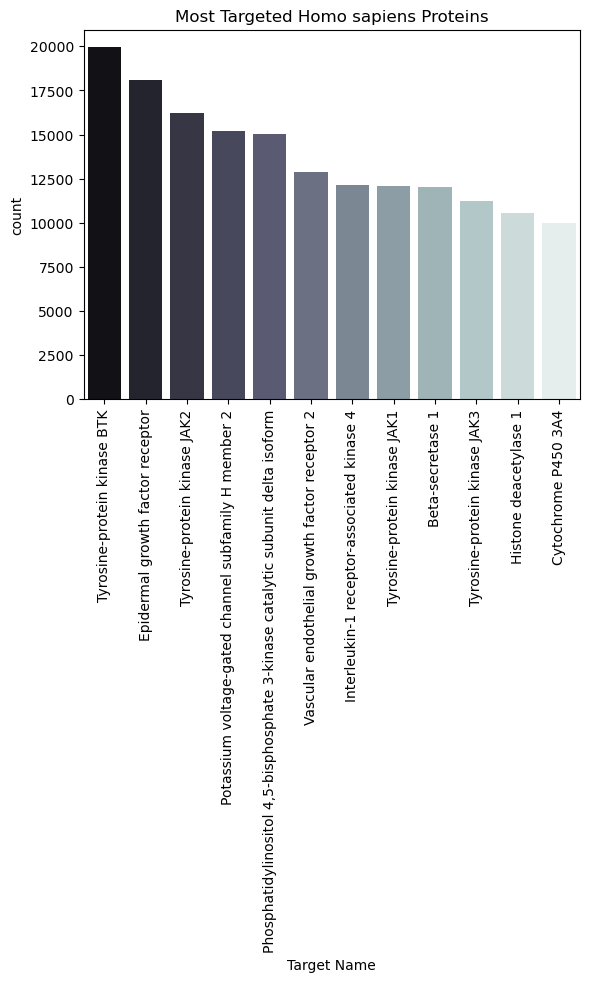

In [12]:

df_IC50 = df_IC50.sort_values(by="IC50 (nM)",ascending=True)

most_targeted = df_IC50.groupby("Target Name").count().sort_values(by="Ligand SMILES", ascending=False)["Ligand SMILES"].head(12)
df_only_most_targeted = df_IC50[df_IC50["Target Name"].isin(most_targeted.index)]
sns.countplot(data = df_only_most_targeted,
              x="Target Name",
              order=most_targeted.index,
              palette="bone",
              )
plt.xticks(rotation = 90)
plt.title("Most Targeted Homo sapiens Proteins")
plt.show()

## Potent Ligands

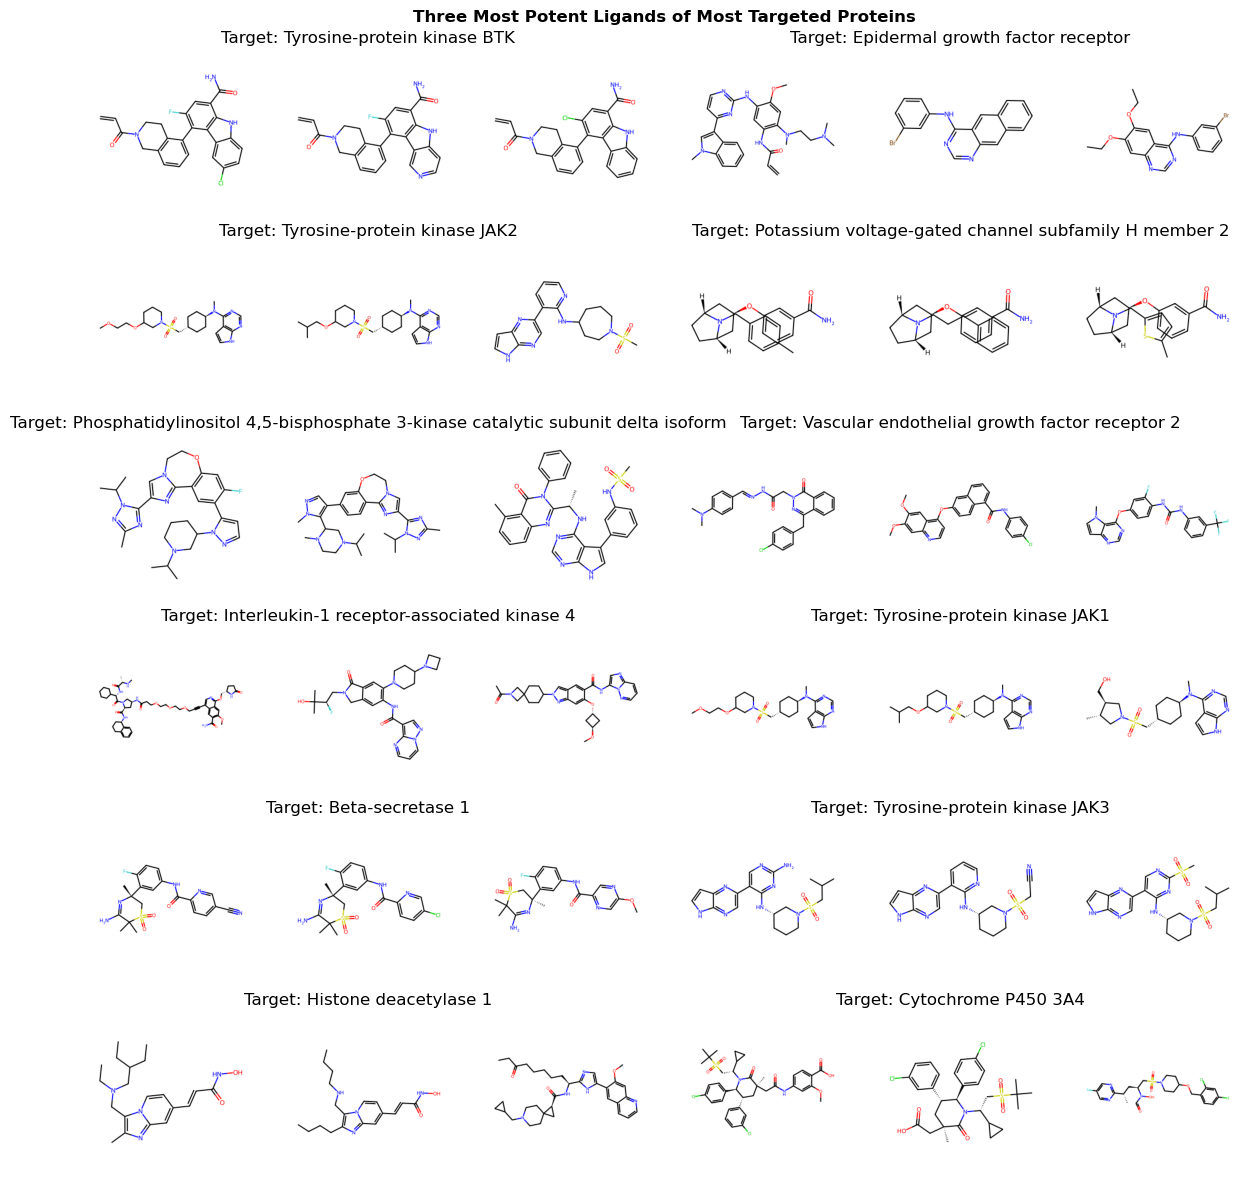

In [13]:
plot_potent_chems(df_with_unique_targets=most_targeted,
                  df_with_chems=df_only_most_targeted,
                  chems_per_target=3,
                  title="Three Most Potent Ligands of Most Targeted Proteins",)

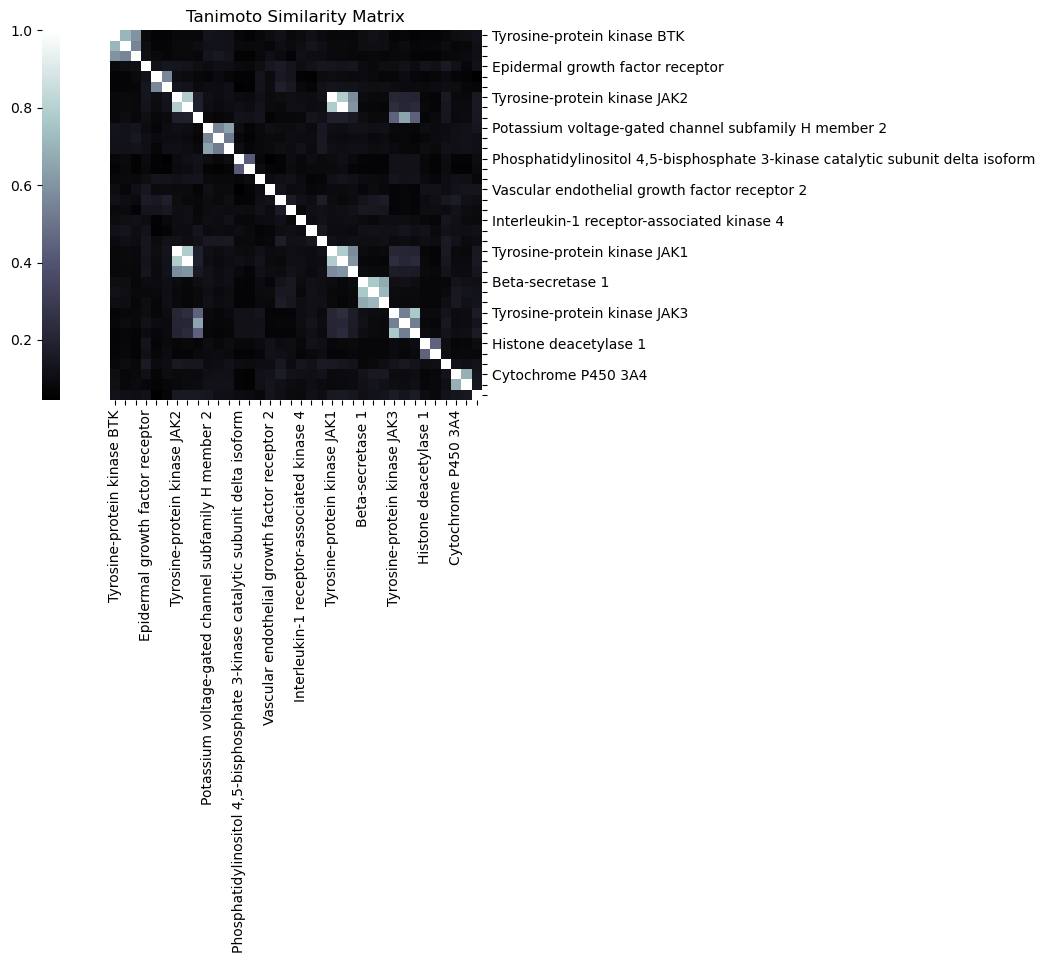

In [14]:
most_potent_stored = []
for target in most_targeted.index:
    most_potent = df_only_most_targeted[df_only_most_targeted["Target Name"]==target].sort_values(by="IC50 (nM)", ascending = True)[:3]
    most_potent_stored.append(most_potent)
most_potent_stored = pd.concat(most_potent_stored)[["Ligand SMILES","Target Name","IC50 (nM)"]]

top_tanimoto_matrix = tanimoto_matrix(chem_df=most_potent_stored,
                     show_every_n_labels=3)

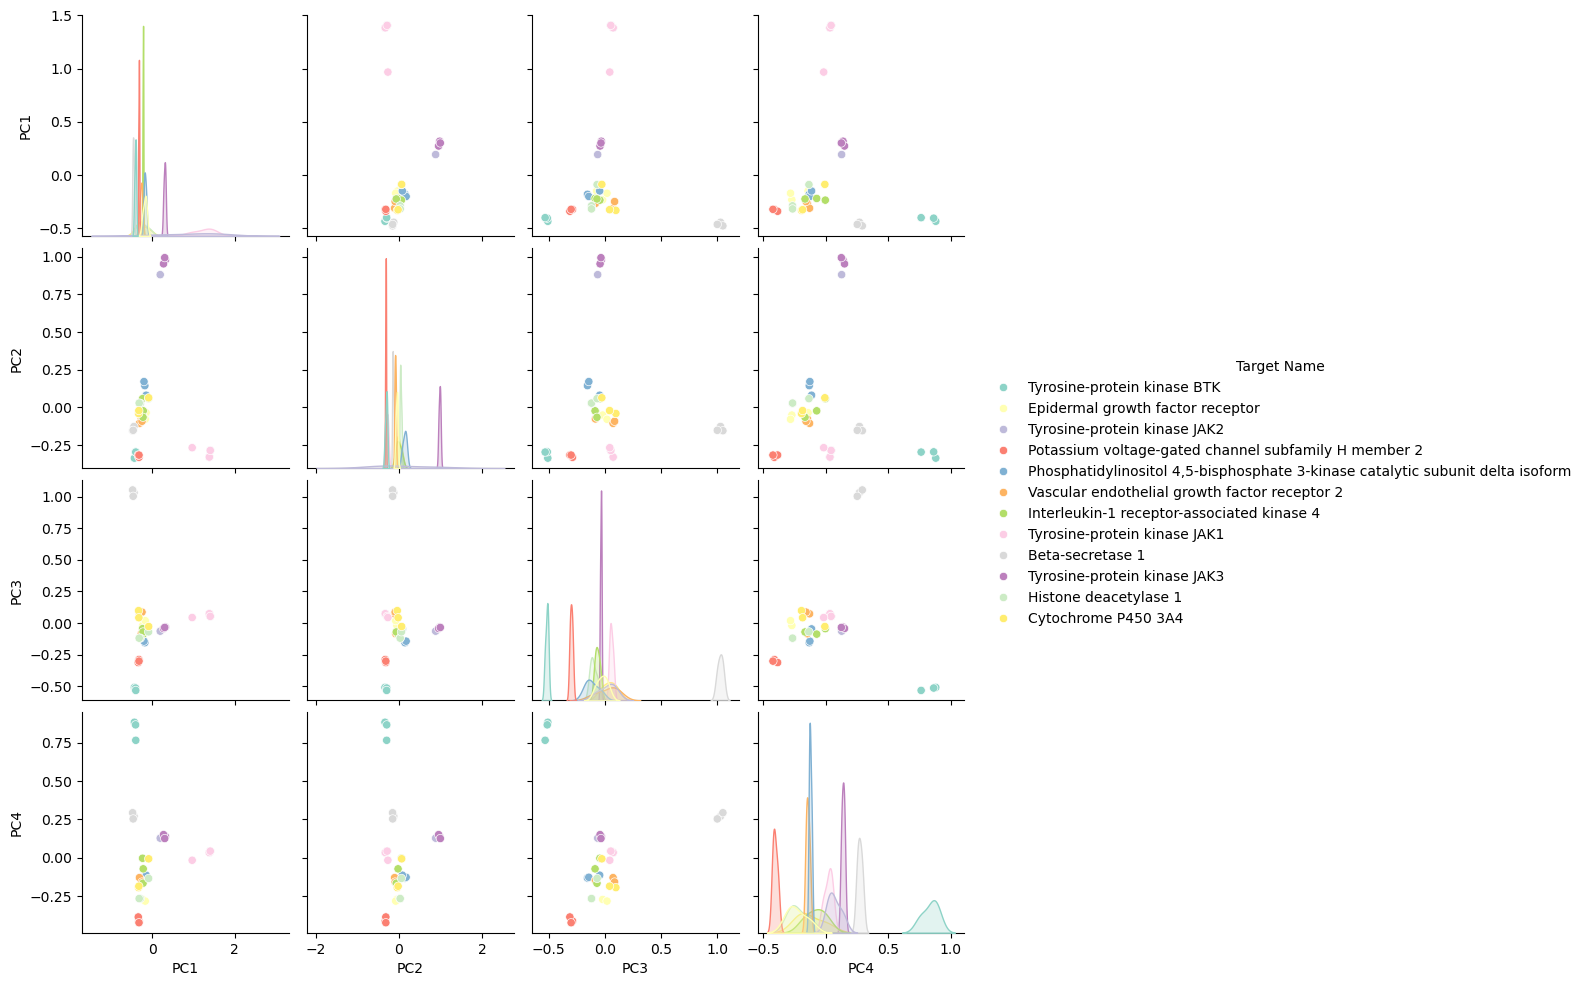

In [15]:
# Apply PCA to the distance matrix
pca = PCA(n_components=5)
pca_coords = pca.fit_transform(top_tanimoto_matrix)

most_potent_PC = pd.concat([most_potent_stored.reset_index(), pd.DataFrame(pca_coords, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])], axis = 1)
# Plot the PCA result
sns.pairplot(data=most_potent_PC[["PC1","PC2","PC3","PC4","Target Name"]],
             hue="Target Name",
             palette="Set3")
plt.show()

## Similarity of top 1000 most potent 
(ignoring most frequently targeted)

C:\Users\grede\AppData\Local\Temp\ipykernel_10876\1032906761.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=top_potent,


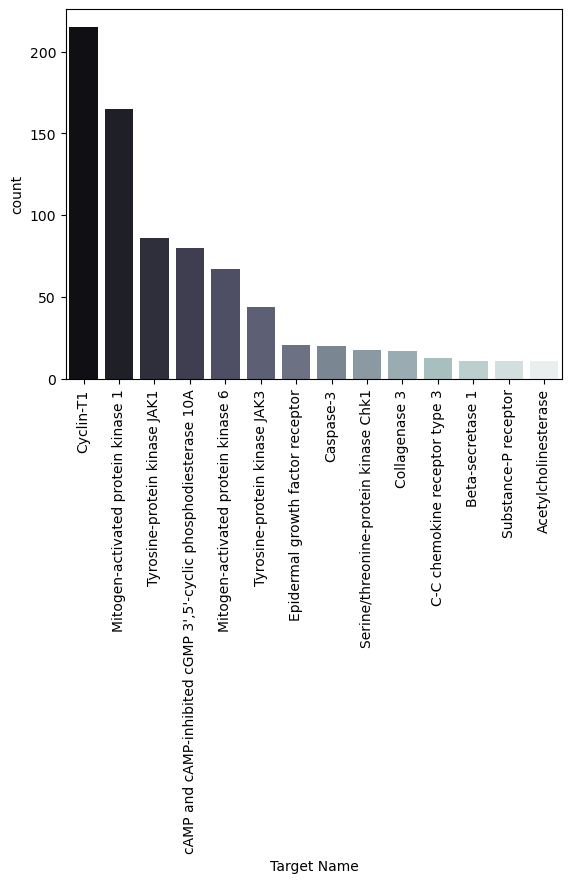

In [16]:
top_potent = df_IC50.reset_index().head(1000) #already filtered by IC50 --> 1000 highest potency (lowest IC50)
high_pot_targets = pd.DataFrame(top_potent["Target Name"].value_counts())
high_pot_targets = high_pot_targets[high_pot_targets["count"]>10]
top_potent = top_potent[top_potent["Target Name"].isin(high_pot_targets.index)] #most potent with more than 10 targets
sns.countplot(data=top_potent,
              x="Target Name",
              order=high_pot_targets.index,
              palette="bone")
plt.xticks(rotation = 90)
plt.show()

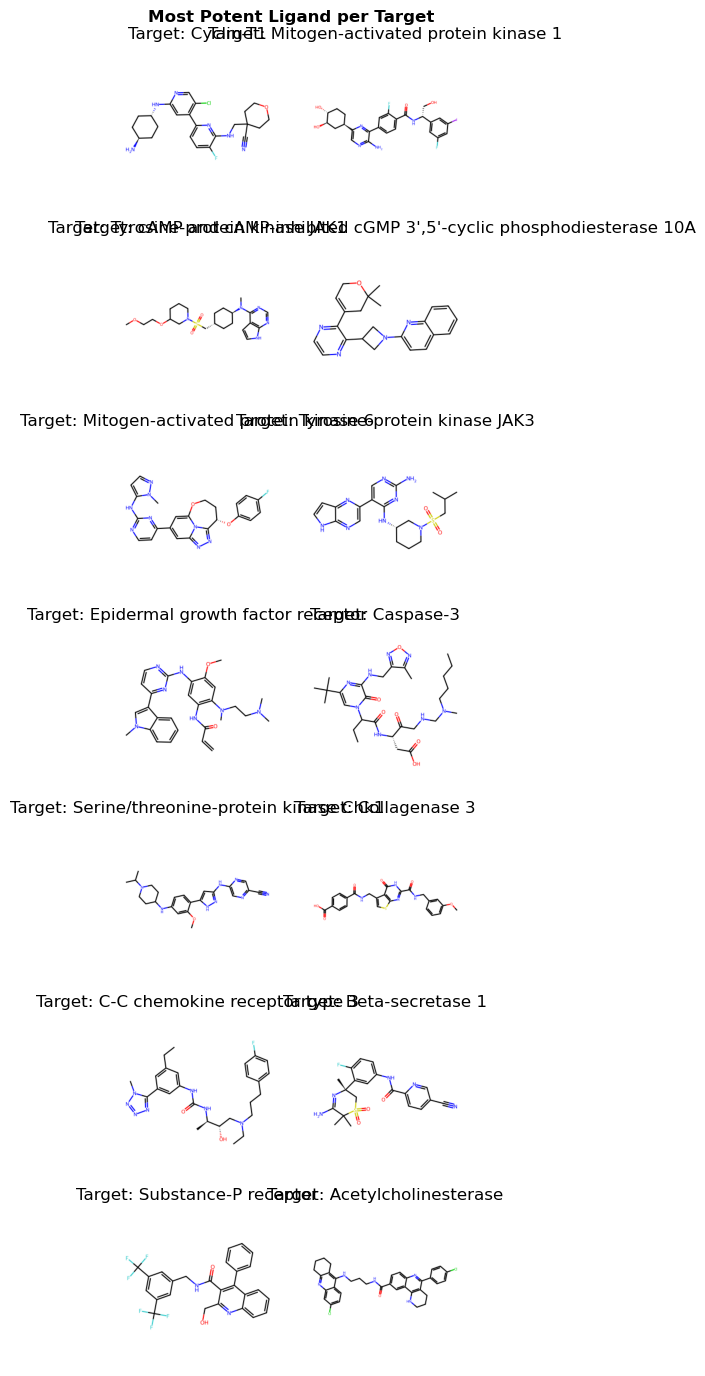

In [17]:
plot_potent_chems(df_with_unique_targets=high_pot_targets,
                  df_with_chems=top_potent,
                  chems_per_target=1,
                  title="Most Potent Ligand per Target")

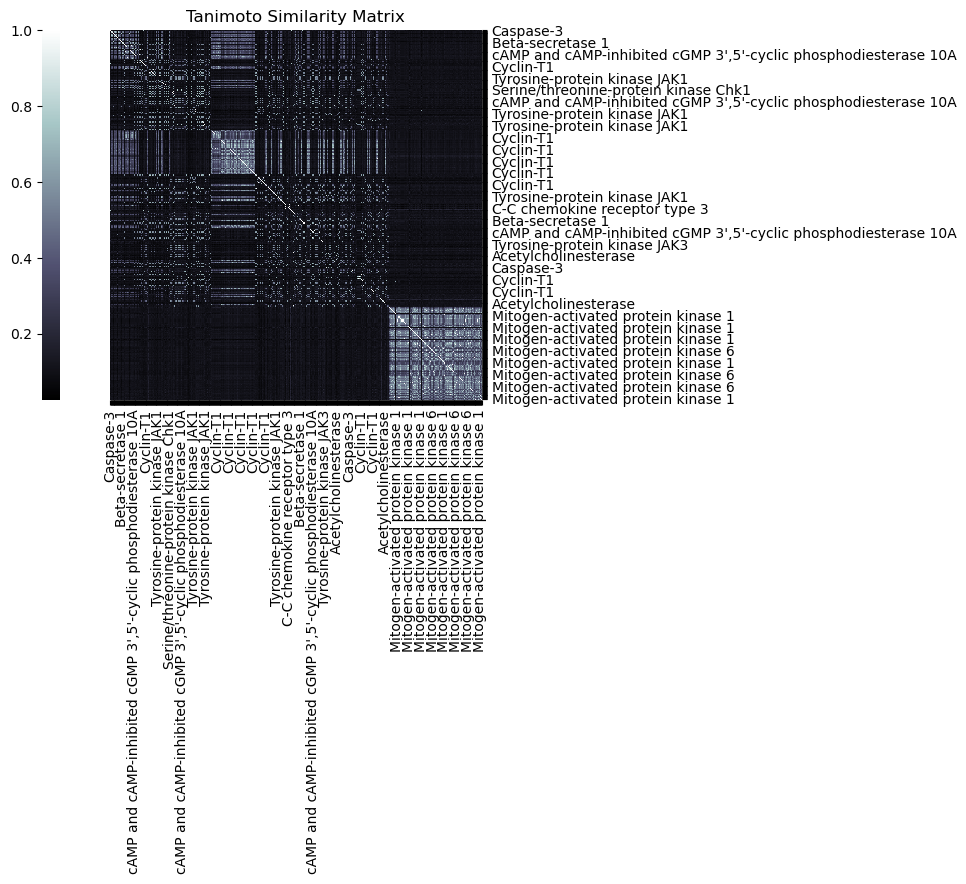

In [18]:
most_potent_tanimoto = tanimoto_matrix(chem_df=top_potent,show_every_n_labels=25)

Things to note/thoughts:
- multiple blocks
- block on bottom is completely seperate from rest -> what is it?
- block in middle is similar to other blocks -> what is it?
- what is this ordered by? --> not target! NEEDS TO BE CORRECTED


Need to do:
- PCA for 1000 top, hue="Target Name"
- DONE function for tanimoto matrix
- DONE function to plot most potent ligands
- figure out order in tanimoto matrix above --> Need correction
- stats about IC50